In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from shapely.geometry import Point, LineString, MultiPolygon, MultiLineString, shape
from descartes import PolygonPatch

from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D

## 1. 导入小区形状数据

其中小区由随机voronoi算法生成。

In [2]:
import fiona

In [3]:
source = fiona.open("../data/boundary_3rd_ring_zones.shp")
zones = [shape(geom["geometry"]) for geom in source]

source = fiona.open("../data/boundary_3rd_ring_districts.shp")
districts = [shape(geom["geometry"]) for geom in source]

source = fiona.open("../data/chengdu_road.shp")
roads = [shape(geom["geometry"]) for geom in source]
roads = [geom for geom in roads if geom.geom_type=="LineString"]

In [4]:
network = MultiPolygon(zones)

## 2. 定义绘图函数

In [5]:
def draw_zones(ax, roads, color_fun=lambda road: "grey"):
    colors = [color_fun(road) for road in roads]
    segs = [PolygonPatch(road) for road in roads]
    line_segs = PatchCollection(segs, facecolor=colors, edgecolor="black")
    ax.add_collection(line_segs)
    
    for i, zone in enumerate(roads):
        ax.text(zone.centroid.x, zone.centroid.y, str(i))
    
def draw_roads(ax, roads, color_fun=lambda road: "blue"):
    colors = [color_fun(road) for road in roads]
    segs = [road.coords for road in roads]
    line_segs = LineCollection(segs, colors=colors)
    ax.add_collection(line_segs)

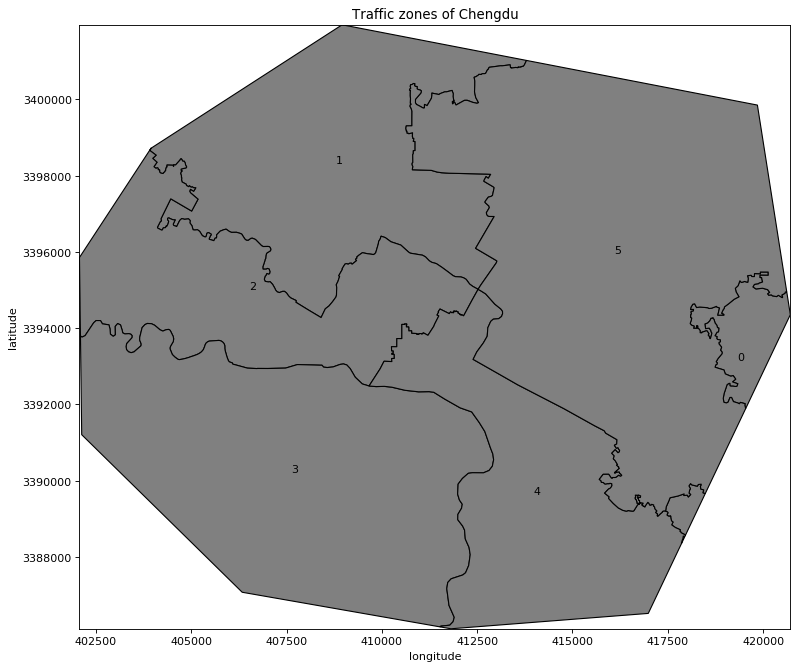

In [6]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Traffic zones of Chengdu")
draw_zones(ax, districts)
plt.show()


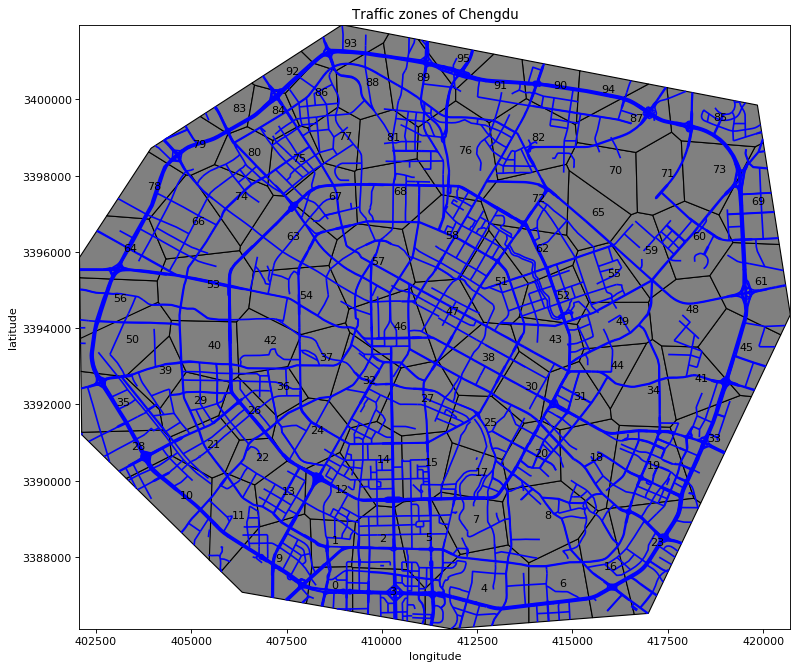

In [7]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Traffic zones of Chengdu")
draw_zones(ax, zones)
draw_roads(ax, roads)
plt.savefig("aaa.png", dpi=300)
plt.show()

## 3. 生成每个小区的人口经济社会指标
采用混合高斯模型（GMM, Gaussian Mixture Model）

In [14]:
x = np.linspace(minx, maxx, 1000)
y = np.linspace(miny, maxy, 1000)
X, Y = np.meshgrid(x, y)

def gauss_2d(X, Y, a, b, c, d, dx, dy):
    X = X - dx
    Y = Y - dy
    Z = 1 / np.exp(a*X*X + (b+c)*X*Y + d*Y*Y)
    return Z

def population_density(X, Y):
    minx, miny, maxx, maxy = network.bounds
    width = maxx - minx
    height = maxy - miny
    center_x = (minx+maxx)/2.0
    center_y = (miny+maxy)/2.0
    X = (X - center_x)/width*2
    Y = (Y - center_y)/height*2
    
    Z = (0.1*gauss_2d(X, Y, 5, 3, 2, 2, 0, 0) +
         0.07*gauss_2d(X, Y, 4, 0.3, 0.4, 4, 0.8, 0.5) +
         0.03*gauss_2d(X, Y, 3, 3, 2, 2, -0.5, -0.7)
        )
    return Z

def attraction_density(X, Y):
    minx, miny, maxx, maxy = network.bounds
    width = maxx - minx
    height = maxy - miny
    center_x = (minx+maxx)/2.0
    center_y = (miny+maxy)/2.0
    X = (X - center_x)/width*2
    Y = (Y - center_y)/height*2
    
    Z = (0.06*gauss_2d(X, Y, 6, 3, 2, 5, 0, 0) +
         0.06*gauss_2d(X, Y, 4, 3, 0.4, 4, 0.1, -0.6) +
         0.06*gauss_2d(X, Y, 10, 3, 2, 10, -0.6, -0.5)
        )
    return Z
    
Z_generation = population_density(X, Y)
Z_attraction = attraction_density(X, Y)

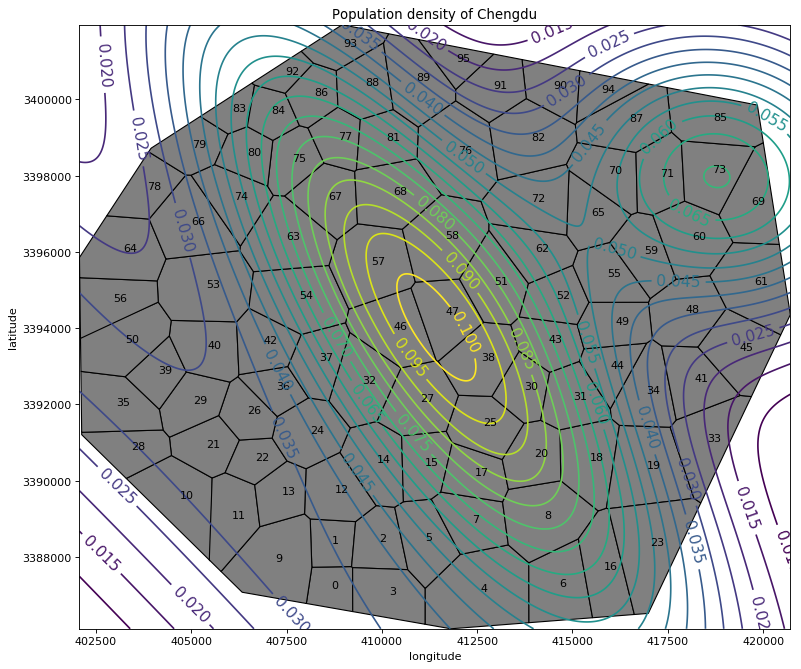

In [15]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

#patches = [PolygonPatch(network)]
#ax.add_collection(PatchCollection(patches, match_original=True))
#for road in roads:
#    x, y = road.xy
#    ax.plot(x, y)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Population density of Chengdu")
draw_zones(ax, zones, lambda road:"grey")
CS = plt.contour(X, Y, Z_generation, 20)
plt.clabel(CS, inline=1, fontsize=14)
plt.show()

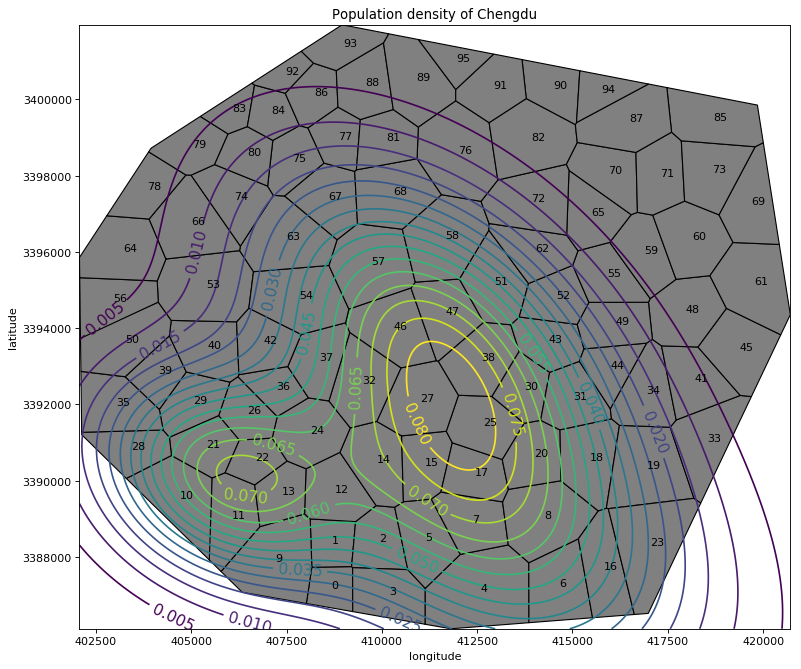

In [16]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

#patches = [PolygonPatch(network)]
#ax.add_collection(PatchCollection(patches, match_original=True))
#for road in roads:
#    x, y = road.xy
#    ax.plot(x, y)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Population density of Chengdu")
draw_zones(ax, zones, lambda road:"grey")
CS = plt.contour(X, Y, Z_attraction, 20)
plt.clabel(CS, inline=1, fontsize=14)
plt.show()

### 3.1 密度积分

In [17]:
def integrate(zone, x, y, Z):
    minx, miny, maxx, maxy = zone.bounds
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    for i in range(len(x)):
        if x[i] >= minx:
            minx = i
            break
    for i in reversed(range(len(x))):
        if x[i] <= maxx:
            maxx = i
            break
    for i in range(len(y)):
        if y[i] >= miny:
            miny = i
            break
    for i in reversed(range(len(y))):
        if y[i] <= maxy:
            maxy = i
            break
            
    total = 0.0        
    for i_x in range(minx, maxx+1):
        for i_y in range(miny, maxy+1):
            point = Point(x[i_x], y[i_y])
            if point.within(zone):
                total += dx*dy*Z[i_y, i_x]
                
    return total            

integrate(zones[0], x, y, Z_generation)

41179.40252801257

In [18]:
zone_populations = {}
zone_attractions = {}
for i, zone in enumerate(zones):
    print(i)
    zone_populations[id(zone)] = integrate(zone, x, y, Z_generation)
    zone_attractions[id(zone)] = integrate(zone, x, y, Z_attraction)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


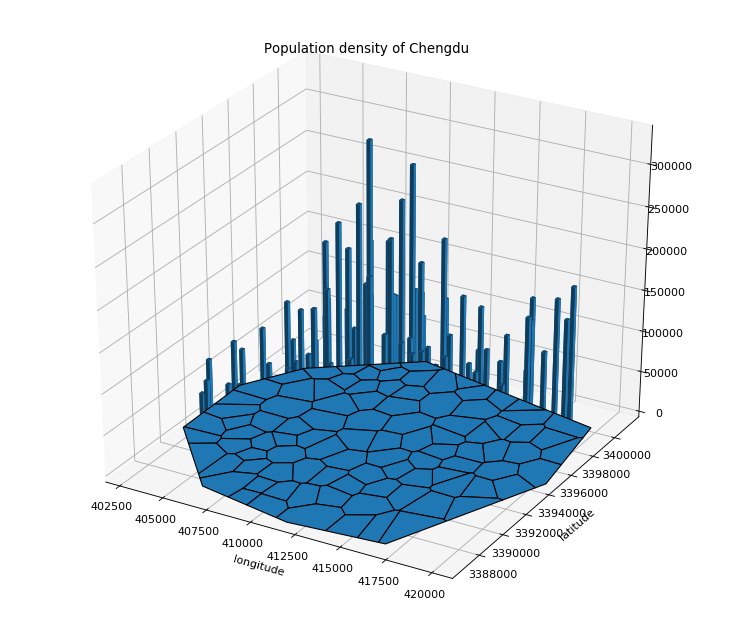

In [67]:
def draw_zones_3d(ax, roads, color_fun=lambda road: "grey"):
    colors = [color_fun(road) for road in roads]
    segs = [PolygonPatch(road) for road in roads]
    #line_segs = PatchCollection(segs, edgecolor="black")
    #ax.add_collection3d(line_segs)
    for seg, color in zip(segs, colors):
        ax.add_patch(seg)
        art3d.pathpatch_2d_to_3d(seg)
    
    #for i, zone in enumerate(roads):
    #    ax.text(zone.centroid.x, zone.centroid.y, str(i))
        
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection="3d")
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Population density of Chengdu")
draw_zones_3d(ax, zones, lambda road:"grey")


bar_x = []
bar_y = []
bar_z = []
for zone in zones:
    bar_x.append(zone.centroid.x)
    bar_y.append(zone.centroid.y)
    bar_z.append(zone_populations[id(zone)])
    
ax.bar3d(bar_x, bar_y, 0, 200, 200, bar_z)

plt.show()

### 3.2 交通分布
单约束重力模型，求小区中心距离矩阵

In [19]:
nzones = len(zones)
dist_matrix = np.zeros((nzones, nzones))

for i, from_zone in enumerate(zones):
    for j, to_zone in enumerate(zones):
        if i == j:
            dist_matrix[i,j] = 1000.0
        else:
            dist_matrix[(i,j)] = from_zone.centroid.distance(to_zone.centroid)   

* 分布

In [20]:
od_matrix = np.zeros((nzones, nzones))
weights = np.zeros(nzones)
for i, from_zone in enumerate(zones):
    for j, to_zone in enumerate(zones):
        weights[j] = zone_attractions[id(to_zone)] / dist_matrix[i, j]**2
    weights /= weights.sum()
    trips = zone_populations[id(to_zone)] * weights
    od_matrix[i] = trips

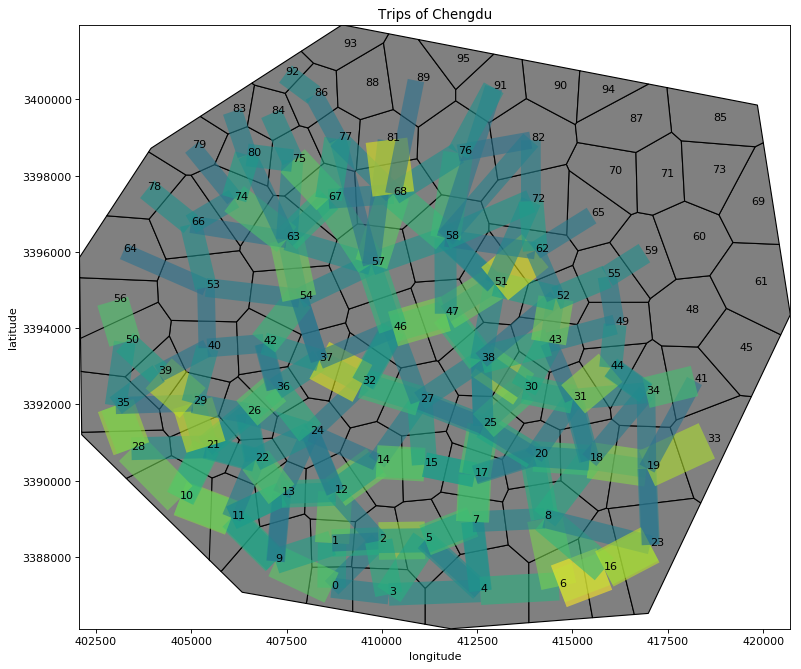

In [21]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Trips of Chengdu")
draw_zones(ax, zones, lambda road:"grey")

cmap = matplotlib.cm.get_cmap("viridis")
segs = []
line_widths = []
colors = []
for i, from_zone in enumerate(zones):
    for j, to_zone in enumerate(zones):
        if od_matrix[i, j] < 1500:
            continue
        segs.append(list(from_zone.centroid.coords)+
                    list(to_zone.centroid.coords))
        line_widths.append(od_matrix[i, j]/100)
        colors.append(cmap(od_matrix[i, j]/4000))
        
line_segs = LineCollection(segs, colors=colors, alpha="0.6", linewidth=line_widths)
ax.add_collection(line_segs)
plt.show()


In [22]:
od_matrix.max()

9472.691186769154

In [23]:
class ZoneData:
    pass

data = {}
for i, zone in enumerate(zones):
    zd = ZoneData()
    zd.population_density = 1
    zd.age_structure = [0.1, 0.2, 0.]
    zd.job_density = 1